Performing Principal Component Analysis and Hierarchical Clustering to group cars into segments on the german market.

Data used in the project can be found on Kaggle:
https://www.kaggle.com/datasets/yaminh/german-car-insights

In [ ]:
#First step is to import necessary libraries and set directory

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

os.chdir("/Users/sbbogdyn/Desktop/PYTHON/CAR PCA AND CLUSTERING")

In [5]:
#Loading the data
data = pd.read_csv("gcar_data.csv")

data.head()

,Unnamed: 0,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,75721,ford,Ford Kuga,black,05/2023,2023,38490,140,190,Automatic,Hybrid,"5,4 l/100 km",124 g/km,100.0,ST-Line Hybrid Adapt.LED+Head-Up-Display Klima
1,80184,hyundai,Hyundai i10,black,09/2018,2018,11555,49,67,Manual,Petrol,"4,6 l/100 km",106 g/km,27782.0,"blue Trend,Viele Extras,Top-Zustand"
2,19864,audi,Audi Q4 e-tron,grey,05/2021,2021,48886,125,170,Automatic,Electric,NaN,0 g/km,4247.0,35 e-tron S line/Matrix/Pano/ACC/SONOS/LM 21
3,76699,honda,Honda CR-V,red,07/2018,2018,24490,114,155,Automatic,Petrol,"7,5 l/100 km",175 g/km,57000.0,2.0 Lifestyle Plus Automatik Navi FAP
4,92991,kia,Kia Sportage,black,02/2023,2023,34990,110,150,Manual,Petrol,"5,9 l/100 km",150 g/km,7500.0,"1.6 T 48V 2WD Spirit LED, WR"


### Cleaning and preparing the data

In [6]:
# After first look we can get rid of few unnecessary variables, which include:
# 1.Unnnamed:0 - variable which was used as an ID in the original dataset
# 2.Brand - brand name is already included in model variable
# 3.Registration_date - most often cars are selected based on production date. What is more, cars are usually registered in the same year as their production date.
# 4.power_kw - dataset already has a variable descibing the engine power in more commonly house ps scale
# 5.fuel_consumption_g_km - similarly to power_kw, the dataset already has a variable describing the fuel consumption
# in more commonly used litres/100km scale
# 6.offer_describtion - this variable will be skipped, however it could be used. This project skips 
# Natural Language Processing, which would be necessary to transform this variable into one suitable for PCA.
# However, it could be transformed to perform sentiment analysis to check whether the offer describtion indicates
# that the car could be seen as premium.


columns_to_drop = ['Unnamed: 0', 'brand', 'registration_date', 'power_kw', 'fuel_consumption_g_km', 'offer_description']
data_1 = data.drop(columns=columns_to_drop)

data_1.head()

,model,color,year,price_in_euro,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km
0,Ford Kuga,black,2023,38490,190,Automatic,Hybrid,"5,4 l/100 km",100.0
1,Hyundai i10,black,2018,11555,67,Manual,Petrol,"4,6 l/100 km",27782.0
2,Audi Q4 e-tron,grey,2021,48886,170,Automatic,Electric,NaN,4247.0
3,Honda CR-V,red,2018,24490,155,Automatic,Petrol,"7,5 l/100 km",57000.0
4,Kia Sportage,black,2023,34990,150,Manual,Petrol,"5,9 l/100 km",7500.0


In [7]:
#Checking whether the are some unnanted values in fuel_type columnn

data_1['fuel_type'].unique()

array(['Hybrid', 'Petrol', 'Electric', 'Diesel', 'LPG', 'Diesel Hybrid',
       'Other', 'CNG', 'Unknown', 'Hydrogen', '160.629 km', '04/2008',
       '01/2016', 'Ethanol', '10/2022', '12/2014', '06/2004', 'Automatic',
       '108.313 km', '74.194 km', '05/2009', '12890', '264.000 km',
       '300.000 km', '04/2013', '03/2019', 'Manual', '11/2021',
       'KETTE NEUE', '110.250 km', '06/2023', '03/2018', '180.000 km',
       '20.600 km', '144.919 km', '08/2014', '03/2017', '12/2012',
       '12/2019', '07/2022', '25890', '04/2022', '12/2016', '07/2007',
       '05/2015', '145.500 km', '11/2018', '07/2004', '08/2018',
       '06/2014', '03/2014', '02/2017', '19450', '09/2009'], dtype=object)

In [13]:
desired_fuel_types = ['Hybrid', 'Petrol', 'Electric', 'Diesel', 'LPG', 'Diesel Hybrid',
                      'Hydrogen']

data_2 = data_1[data_1['fuel_type'].isin(desired_fuel_types)]

data_2['fuel_type'].unique()

array(['Hybrid', 'Petrol', 'Electric', 'Diesel', 'LPG', 'Diesel Hybrid',
       'Hydrogen'], dtype=object)

In [16]:
#To include fuel_type data in PCA analysis, we need to convert it to some kind of
#numerical value. To achieve that, we will use categorize them into two categories:
# 1. ecofuels
# 2. nonecofuels

fuel_map = {
    'Hybrid': 1, 
    'Electric': 1, 
    'Diesel Hybrid': 1, 
    'Hydrogen': 1,
    'Petrol': 0, 
    'Diesel': 0, 
    'LPG': 0
}

data_2.loc[:, 'fuel_numeric'] = data_2['fuel_type'].map(fuel_map)
data_2 = data_2.drop(columns=['fuel_type'])


data_2

,model,color,year,price_in_euro,power_ps,transmission_type,fuel_consumption_l_100km,mileage_in_km,fuel_numeric
0,Ford Kuga,black,2023,38490,190,Automatic,"5,4 l/100 km",100.0,1
1,Hyundai i10,black,2018,11555,67,Manual,"4,6 l/100 km",27782.0,0
2,Audi Q4 e-tron,grey,2021,48886,170,Automatic,NaN,4247.0,1
3,Honda CR-V,red,2018,24490,155,Automatic,"7,5 l/100 km",57000.0,0
4,Kia Sportage,black,2023,34990,150,Manual,"5,9 l/100 km",7500.0,0
...,...,...,...,...,...,...,...,...,...
99995,Audi A1,blue,2012,12599,122,Manual,"5,3 l/100 km",148000.0,0
99996,Fiat 500,black,2019,9999,69,Automatic,"5,2 l/100 km",31698.0,0
99997,Honda CR-V,brown,2019,24800,173,Manual,"6,3 l/100 km",77900.0,0
99998,Alfa Romeo Giulietta,grey,2020,22990,170,Automatic,"5,5 l/100 km",52251.0,0


In [208]:
#Checking whether the are some unwanted values in power_ps columnn
data_2['power_ps'].astype(float)
data_2['power_ps'].unique()

array(['190', '67', '170', '155', '150', '140', '177', '120', '82', '91',
       '163', '394', '204', '105', '193', '101', '125', '333', '258',
       '160', '143', '116', '300', '265', '230', '200', '90', '141',
       '530', '95', '87', '401', '351', '370', '136', '640', '173', '209',
       '241', '381', '252', '135', '179', '184', '165', '390', '211',
       '69', '129', '354', '600', '299', '721', '192', '272', '770',
       '525', '99', '185', '510', '151', '364', nan, '197', '75', '326',
       '114', '286', '86', '306', '145', '280', '175', '400', '320',
       '551', '349', '513', '250', '109', '71', '218', '45', '118', '275',
       '110', '245', '181', '313', '450', '60', '290', '84', '80', '83',
       '131', '132', '166', '421', '374', '147', '385', '460', '220',
       '212', '408', '489', '256', '605', '231', '347', '156', '68', '63',
       '182', '330', '224', '309', '340', '122', '700', '468', '431',
       '249', '420', '232', '659', '575', '519', '518', '430', '239'

In [19]:
#Checking whether the are some unwanted values in transmission_type columnn
data_2['transmission_type'].unique()


array(['Automatic', 'Manual', 'Unknown', 'Semi-automatic'], dtype=object)

In [23]:
#To include transmission_type data in PCA analysis, we need to convert it to some kind of
#numerical value. To achieve that, we will assign them values from 0 to 1 indicating level
#of automation of the gearbox

data_3 = data_2[data_2['transmission_type'] != 'Unknown']

transmission_map = {
    'Automatic': 1,
    'Manual': 0,
    'Semi-automatic': 0.5
}

#Mapping
data_3['transmission_automation'] = data_3['transmission_type'].map(transmission_map)

#Removing original variable from df
data_3.drop(columns=['transmission_type'], inplace=True)

data_3

/var/folders/js/5ml0znms427420p97602n8qm0000gn/T/ipykernel_20783/3806525734.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_3['transmission_automation'] = data_3['transmission_type'].map(transmission_map)
/var/folders/js/5ml0znms427420p97602n8qm0000gn/T/ipykernel_20783/3806525734.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_3.drop(columns=['transmission_type'], inplace=True)


,model,color,year,price_in_euro,power_ps,fuel_consumption_l_100km,mileage_in_km,fuel_numeric,transmission_automation
0,Ford Kuga,black,2023,38490,190,"5,4 l/100 km",100.0,1,1.0
1,Hyundai i10,black,2018,11555,67,"4,6 l/100 km",27782.0,0,0.0
2,Audi Q4 e-tron,grey,2021,48886,170,NaN,4247.0,1,1.0
3,Honda CR-V,red,2018,24490,155,"7,5 l/100 km",57000.0,0,1.0
4,Kia Sportage,black,2023,34990,150,"5,9 l/100 km",7500.0,0,0.0
...,...,...,...,...,...,...,...,...,...
99995,Audi A1,blue,2012,12599,122,"5,3 l/100 km",148000.0,0,0.0
99996,Fiat 500,black,2019,9999,69,"5,2 l/100 km",31698.0,0,1.0
99997,Honda CR-V,brown,2019,24800,173,"6,3 l/100 km",77900.0,0,0.0
99998,Alfa Romeo Giulietta,grey,2020,22990,170,"5,5 l/100 km",52251.0,0,1.0


In [77]:
#Checking whether the are some unwanted values in fuel_consumption_100km columnn
data_3['fuel_consumption_l_100km'].unique()


array(['5,4 l/100 km', '4,6 l/100 km', 'nan', '7,5 l/100 km',
       '5,9 l/100 km', '6,7 l/100 km', '8,9 l/100 km', '5,6 l/100 km',
       '5 l/100 km', '7,4 l/100 km', '8,2 l/100 km', '9,4 l/100 km',
       '3,8 l/100 km', '5,3 l/100 km', '6,9 l/100 km', '7,2 l/100 km',
       '8,4 l/100 km', '4,7 l/100 km', '6,1 l/100 km', '6,3 l/100 km',
       '4,9 l/100 km', '4,8 l/100 km', '4,5 l/100 km', '6,2 l/100 km',
       '6,6 l/100 km', '9,3 l/100 km', '4,1 l/100 km', '8,3 l/100 km',
       '4,4 l/100 km', '9,9 l/100 km', '4,3 l/100 km', '6,4 l/100 km',
       '7,6 l/100 km', '7,9 l/100 km', '5,8 l/100 km', '2 l/100 km',
       '12,3 l/100 km', '5,5 l/100 km', '5,2 l/100 km', '6 l/100 km',
       '6,8 l/100 km', '5,1 l/100 km', '7,8 l/100 km', '0 kWh/100 km',
       '3,9 l/100 km', '12,1 l/100 km', '17,9 l/100 km', '12,7 l/100 km',
       '10,2 l/100 km', '1,8 l/100 km', '3,5 l/100 km', '8,1 l/100 km',
       '11,7 l/100 km', '11 l/100 km', '16,9 l/100 km', '7,7 l/100 km',
       '6,5 l/1

In [78]:
data_3.loc[:, 'fuel_consumption_l_100km'] = data_3['fuel_consumption_l_100km'].astype(str)

data_4 = data_3[~data_3['fuel_consumption_l_100km'].str.contains('- ()', regex=False)]
data_4 = data_4[~data_4['fuel_consumption_l_100km'].str.contains('nan', regex=False)]

data_4['fuel_consumption_l_100km'].unique()

array(['5,4 l/100 km', '4,6 l/100 km', '7,5 l/100 km', '5,9 l/100 km',
       '6,7 l/100 km', '8,9 l/100 km', '5,6 l/100 km', '5 l/100 km',
       '7,4 l/100 km', '8,2 l/100 km', '9,4 l/100 km', '3,8 l/100 km',
       '5,3 l/100 km', '6,9 l/100 km', '7,2 l/100 km', '8,4 l/100 km',
       '4,7 l/100 km', '6,1 l/100 km', '6,3 l/100 km', '4,9 l/100 km',
       '4,8 l/100 km', '4,5 l/100 km', '6,2 l/100 km', '6,6 l/100 km',
       '9,3 l/100 km', '4,1 l/100 km', '8,3 l/100 km', '4,4 l/100 km',
       '9,9 l/100 km', '4,3 l/100 km', '6,4 l/100 km', '7,6 l/100 km',
       '7,9 l/100 km', '5,8 l/100 km', '2 l/100 km', '12,3 l/100 km',
       '5,5 l/100 km', '5,2 l/100 km', '6 l/100 km', '6,8 l/100 km',
       '5,1 l/100 km', '7,8 l/100 km', '0 kWh/100 km', '3,9 l/100 km',
       '12,1 l/100 km', '17,9 l/100 km', '12,7 l/100 km', '10,2 l/100 km',
       '1,8 l/100 km', '3,5 l/100 km', '8,1 l/100 km', '11,7 l/100 km',
       '11 l/100 km', '16,9 l/100 km', '7,7 l/100 km', '6,5 l/100 km',
      

In [79]:
#Changing the variable to 'str' type

data_4['fuel_consumption_l_100km'] = data_4['fuel_consumption_l_100km'].astype(str)

#Removing unnecessary fragments
patterns = [r'kg/100 km', r'l/100 km', r'kWh/100 km', r' km \(Ort\)', r'- \(l/100 km\)', r'- \(\)', r'\(\)']

for pattern in patterns:
    data_4['fuel_consumption_l_100km'] = data_4['fuel_consumption_l_100km'].str.replace(pattern, '', regex=True)

data_4 = data_4[data_4['fuel_consumption_l_100km'].str.strip() != '']

data_4['fuel_consumption_l_100km'] = data_4['fuel_consumption_l_100km'].str.replace(',', '.').astype(float)


In [80]:
#Checking whether the are some unwanted values in year columnn
data_4['year'].unique()

array(['2023', '2018', '2009', '2019', '2012', '2022', '2016', '2005',
       '1999', '2015', '2004', '2020', '2021', '2011', '2017', '2010',
       '2013', '2014', '2007', '2003', '2008', '2001', '1998', '2002',
       '2006', '1997', '2000', '1996', '1995'], dtype=object)

In [81]:
#For purpose of our analysis, it would be easier to change the date of production to car age

data_4['year'] = data_4['year'].astype(float)

data_4['car_age'] = 2024 - data_4['year']

data_4 = data_4.drop(columns=['year'])



In [82]:
#Checking whether the are some unwanted values in fuel_consumption_100km columnn
data_4['price_in_euro'] = data_4['price_in_euro'].astype(float)
data_4['price_in_euro']

0        38490.0
1        11555.0
3        24490.0
4        34990.0
5         5800.0
          ...   
99995    12599.0
99996     9999.0
99997    24800.0
99998    22990.0
99999    21900.0
Name: price_in_euro, Length: 87860, dtype: float64

In [83]:
#Checking whether the are some unwanted values in mileage_in_km columnn
data_4['mileage_in_km'].astype(float)

0           100.0
1         27782.0
3         57000.0
4          7500.0
5        160000.0
           ...   
99995    148000.0
99996     31698.0
99997     77900.0
99998     52251.0
99999     30400.0
Name: mileage_in_km, Length: 87860, dtype: float64

In [84]:
#Dropping any remaining rows with missing values
data_4.dropna()

,model,color,price_in_euro,power_ps,fuel_consumption_l_100km,mileage_in_km,fuel_numeric,transmission_automation,car_age
0,Ford Kuga,black,38490.0,190,5.4,100.0,1,1.0,1.0
1,Hyundai i10,black,11555.0,67,4.6,27782.0,0,0.0,6.0
3,Honda CR-V,red,24490.0,155,7.5,57000.0,0,1.0,6.0
4,Kia Sportage,black,34990.0,150,5.9,7500.0,0,0.0,1.0
5,Honda Civic,black,5800.0,140,6.7,160000.0,0,0.0,15.0
...,...,...,...,...,...,...,...,...,...
99995,Audi A1,blue,12599.0,122,5.3,148000.0,0,0.0,12.0
99996,Fiat 500,black,9999.0,69,5.2,31698.0,0,1.0,5.0
99997,Honda CR-V,brown,24800.0,173,6.3,77900.0,0,0.0,5.0
99998,Alfa Romeo Giulietta,grey,22990.0,170,5.5,52251.0,0,1.0,4.0


### Principal Compoments Analysis

After preparing our data we can transition to PCA

In [85]:
#First step of PCA will be to standardize our variables

columns_to_scale = data_4.select_dtypes(include=[np.number]).columns.tolist()
columns_to_scale = [col for col in columns_to_scale if col not in ['Model', 'Color']]


scaler = StandardScaler()

data_4[columns_to_scale] = scaler.fit_transform(data_4[columns_to_scale])

print(data_4)

                      model  color  price_in_euro power_ps  \
0                 Ford Kuga  black       0.239544      190   
1               Hyundai i10  black      -0.361240       67   
3                Honda CR-V    red      -0.072725      155   
4              Kia Sportage  black       0.161477      150   
5               Honda Civic  black      -0.489605      140   
...                     ...    ...            ...      ...   
99995               Audi A1   blue      -0.337954      122   
99996              Fiat 500  black      -0.395947       69   
99997            Honda CR-V  brown      -0.065811      173   
99998  Alfa Romeo Giulietta   grey      -0.106183      170   
99999               Audi A3  black      -0.130495      150   

       fuel_consumption_l_100km  mileage_in_km  fuel_numeric  \
0                     -0.085240      -1.106245      4.736621   
1                     -0.127730      -0.760400     -0.211121   
3                      0.026297      -0.395364     -0.211121   

In [86]:
#After standardizing our dataset, the next thing to do would be creating covariannce matrix

numeric_cols = data_4.select_dtypes(include=[np.number]).columns.tolist()
data_4[numeric_cols] = scaler.fit_transform(data_4[numeric_cols])

covariance_matrix = data_4[numeric_cols].cov()

print(covariance_matrix)

                          price_in_euro  fuel_consumption_l_100km  \
price_in_euro                  1.000011                  0.061101   
fuel_consumption_l_100km       0.061101                  1.000011   
mileage_in_km                 -0.261243                 -0.034424   
fuel_numeric                   0.059786                  0.158543   
transmission_automation        0.265299                  0.055495   
car_age                       -0.266085                 -0.016563   

                          mileage_in_km  fuel_numeric  \
price_in_euro                 -0.261243      0.059786   
fuel_consumption_l_100km      -0.034424      0.158543   
mileage_in_km                  1.000011     -0.181082   
fuel_numeric                  -0.181082      1.000011   
transmission_automation       -0.069835      0.118589   
car_age                        0.718863     -0.204531   

                          transmission_automation   car_age  
price_in_euro                            0.265299 -0.2

In [87]:
#The next step is to calculate eigenvalues and eigenvectors of the coviarance matrix

eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

Eigenvalues:
[2.05636859 0.2678288  0.68325373 0.83965646 1.03947903 1.11348168]

Eigenvectors:
[[-0.38455926 -0.03998422 -0.68975118 -0.31609299  0.51352277  0.10553828]
 [-0.10752986 -0.02653031  0.21188641 -0.59637044 -0.30917542  0.70113513]
 [ 0.57085385 -0.69234999 -0.11428902  0.14121183  0.24078199  0.32217797]
 [-0.28283872  0.01232975 -0.38592348  0.63765331 -0.42482821  0.42875699]
 [-0.2836781   0.14010349  0.51070531  0.34281776  0.61900204  0.37200846]
 [ 0.5951524   0.7060934  -0.23775751  0.01899934  0.13815364  0.26692639]]


In [88]:
#After calculating eigenvalues, we will then sort them along with their corresponding eigenvectors

sorted_indices = np.argsort(eigenvalues)[::-1]  
sorted_eigenvalues = eigenvalues[sorted_indices]


sorted_eigenvectors = eigenvectors[:, sorted_indices]

print("Sorted Eigenvalues:")
print(sorted_eigenvalues)
print("\nSorted Eigenvectors:")
print(sorted_eigenvectors)

Sorted Eigenvalues:
[2.05636859 1.11348168 1.03947903 0.83965646 0.68325373 0.2678288 ]

Sorted Eigenvectors:
[[-0.38455926  0.10553828  0.51352277 -0.31609299 -0.68975118 -0.03998422]
 [-0.10752986  0.70113513 -0.30917542 -0.59637044  0.21188641 -0.02653031]
 [ 0.57085385  0.32217797  0.24078199  0.14121183 -0.11428902 -0.69234999]
 [-0.28283872  0.42875699 -0.42482821  0.63765331 -0.38592348  0.01232975]
 [-0.2836781   0.37200846  0.61900204  0.34281776  0.51070531  0.14010349]
 [ 0.5951524   0.26692639  0.13815364  0.01899934 -0.23775751  0.7060934 ]]


In [89]:
#Having the eigenvalues calculated and sorted we can move on to selecting the number of 
#principal components

#Normalizing the eigenvalues to sum to 1
normalized_eigenvalues = sorted_eigenvalues / sorted_eigenvalues.sum()

#Calculating cumulative variance explained
cumulative_variance = np.cumsum(normalized_eigenvalues)

#Calculating additional variance explained by each new variable
additional_variance = np.diff(cumulative_variance, prepend=0)

#Creating a new table to showcase data for each variable
result = []
for i, (cum_var, add_var) in enumerate(zip(cumulative_variance, additional_variance), start=1):
    result.append([i, cum_var, add_var])

for line in result:
    print("Variable", line[0], ": Cumulative Variance =", format(line[1], ".4f"), 
          ", Additional Variance =", format(line[2], ".4f"))

Variable 1 : Cumulative Variance = 0.3427 , Additional Variance = 0.3427
Variable 2 : Cumulative Variance = 0.5283 , Additional Variance = 0.1856
Variable 3 : Cumulative Variance = 0.7015 , Additional Variance = 0.1732
Variable 4 : Cumulative Variance = 0.8415 , Additional Variance = 0.1399
Variable 5 : Cumulative Variance = 0.9554 , Additional Variance = 0.1139
Variable 6 : Cumulative Variance = 1.0000 , Additional Variance = 0.0446


In [90]:
#Having the table displayed, we can now decided how many variables we would like to include in the model.
#One of the frameworks of choosing the number of variables is to follow two rules:
#1. Cumulative Variance should be over 0.8
#2. Non of the remaining variables should provible Additional Variance of more then 0.05
#
#With that in mind, the number of variables that should be included in the model is 5.

top_5_eigenvectors = eigenvectors[:, :5]

transformed_data = np.dot(covariance_matrix, top_5_eigenvectors)

transformed_data

array([[-0.79079558, -0.01070893, -0.47127507, -0.26540952,  0.53379616],
       [-0.22112103, -0.00710558,  0.14477218, -0.50074629, -0.32138136],
       [ 1.17388593, -0.18543127, -0.0780884 ,  0.11856942,  0.25028783],
       [-0.58162067,  0.00330226, -0.26368366,  0.53540972, -0.44160002],
       [-0.58334673,  0.03752375,  0.34894131,  0.28784915,  0.64343964],
       [ 1.2238527 ,  0.18911215, -0.16244871,  0.01595292,  0.14360781]])

In [91]:
#Calculating the loadings
loadings = eigenvectors * np.sqrt(eigenvalues[:, np.newaxis])

#Creating a DataFrame for the loadings
variable_names = [
    'price_in_euro', 'fuel_consumption_l_100km', 'mileage_in_km', 'fuel_numeric', 'transmission_automation',
     'car_age'  
]

if len(variable_names) != eigenvectors.shape[0]:
    raise ValueError(f"Number of variable names ({len(variable_names)}) does not match number of eigenvector rows ({eigenvectors.shape[0]})")

loadings_df = pd.DataFrame(loadings, 
                           columns=[f'PC{i+1}' for i in range(loadings.shape[1])],
                           index=variable_names)

#Highlighting the top 3 loadings for each PC
def highlight_top3(s):
    is_top3 = pd.Series(data=False, index=s.index)
    is_top3[s.abs().nlargest(3).index] = True
    return ['background-color: yellow' if v else '' for v in is_top3]

styled_loadings_df = loadings_df.style.apply(highlight_top3)

styled_loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
price_in_euro,-0.551460,-0.057338,-0.989106,-0.453279,0.736394,0.151342
fuel_consumption_l_100km,-0.055649,-0.013730,0.109656,-0.308635,-0.160005,0.362853
mileage_in_km,0.471863,-0.572291,-0.094470,0.116725,0.199028,0.266310
fuel_numeric,-0.259173,0.011298,-0.353632,0.584299,-0.389282,0.392882
transmission_automation,-0.289224,0.142842,0.520689,0.349519,0.631103,0.379281
car_age,0.628015,0.745081,-0.250886,0.020048,0.145782,0.281665


In [ ]:
#Based on the highlighted values in the table above, which shows loads for each Principal Component, we can
#assume which variables are mostly correlated to each PC.


The Principal Compoment Analysis did lead to reduction in number of variables used in the model.
Instead of 6 original variables we can opt to go with 5 Principal Components

What are the conclusions from this analysis and possible future steps that should be undertaken:

All fuel type, transmission type, car age, car mileage, power and fuel consumption are all equally important
aspects of car that clients take into consideration, and as the Principal Component Analysis has shown, it is
impossible to reduce the number of variables without loosing significant portion of variance explanation.

What could be done to expand the project:

As it was mentioned in the data cleaning part, the dataset involved car specification text data. This data could be transformed to a format suitable from this analysis with use of Natural Language Processing, such as
'bag of words' to extract data for each car regarding, e.g. version of interior of the car, as certain features
such as LED lights.

### Hierarchical Car Clustering

After performing the Principal Component Analysis, we can move on to the second part of the project, which
would be the car clustering. The purpose of that, is to find cars similar to each other, so that clients
who decided not to go with their initial car were offered a choice of other, similar cars.

In [92]:
#First step is to create a new dataset containing model of the car, color of the car and principal components 
#calculated in the previous part. Both model of the car, as well as the color are

transformed_data = np.dot(data_4[numeric_cols], top_5_eigenvectors)


data_PC = pd.concat([data_4[['model', 'color']], pd.DataFrame(transformed_data, columns=[f'PC{i+1}' for i in range(5)])], axis=1)

data_PC.head()

,model,color,PC1,PC2,PC3,PC4,PC5
0,Ford Kuga,black,-3.100585,0.035610,-1.083214,3.145471,-1.711091
1,Hyundai i10,black,-0.128294,0.158074,-0.059043,-0.413662,-0.928139
3,Honda CR-V,red,-1.053140,-0.367556,-0.147588,-0.674101,-0.874794
4,Kia Sportage,black,1.881211,0.237579,-0.546800,-0.173486,-0.391901
5,Honda Civic,black,-1.871854,-0.049741,0.589665,-0.245835,0.539604


Now we can move on to hierarchical clustering of the car models. We will be using Ward Method for Clustering.
However, to create a dendrogram for such scale, it would require significant amount of computing power. Therefore, a demo dendrogram will only analyse first 20 rows from the dataset


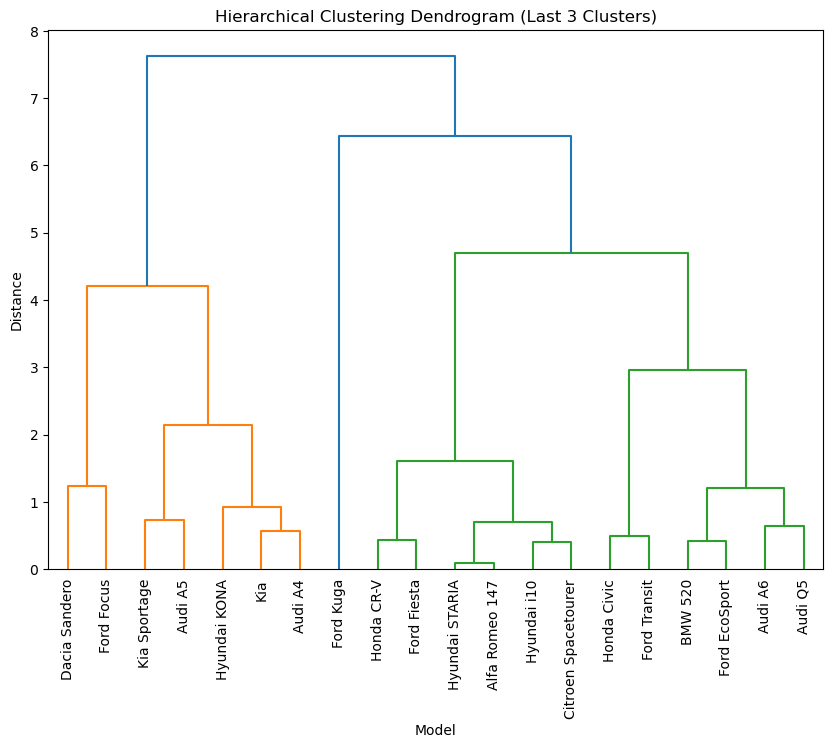

In [95]:
data_PC_subset = data_PC.head(20)

#Extracting the variables for clustering
variables = data_PC_subset[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

#Performinng hierarchical clustering using the Ward Method
Z = linkage(variables, method='ward')

#Creating the dendrogram plot
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=data_PC_subset['model'].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Model')
plt.ylabel('Distance')
plt.show()

Hierarchical Clustering Overview:

Based on first 20 observationns from our dataset, we can observe 18 clusters being created.
The interpretation of the plot is:

Cars with the lowest distances (y axis), are the cars most similar to each other: e.g. Hyundai STARIA annd Alfa Romeo 147. The higher the distance, the bigger difference between the cars.

How does the clustering help potential clients:

Let's assume our client was first interested in the Alfa Romeo 147, however the car was not available or there were some defects, which made the client reject the Alfa Romeo 147. Therefore, the next car that should be showcased to the client is Hyundai STARIA. If this car is also rejected, next cars that should be showcased are
Hyundai i10 and Citroen Spacetourer. However, those cars vary more from the original Alfa Romeo. If this cluster is also rejected, we can move on to Honda CR-V and Ford Fiesta cluster, further more expanding the differences between original car and the offered cars.

### Final Thoughts

Original dataset contained 100000 observations of cars listed on the german car market.
After removing observations with missing data, or removing cars with rare state: such as ethanol fueled cars,
we were left with close to 90000 observations. 
Later after transforming the data to numeric format, Principal Component Analysis has been performed, which led
to a decrease in number of variables from original 6 to 5, as the last variable did not contribute more than 0.05 additional variance explanation.
Then after creating a new dataframe with car models and selected principal components, hierachical clustering with Ward method has been performed. This resulted in creation on a demo dendrogram.

What more could be done:

As mentioned earlier in the data cleaning part, each variable had an additional info about the car version, interior etc. This column was skipped. However, with use of Natural Language Processing, we could transform this variable into numeric one, which could showcase the level of premium equipment in the car on 0 to 1 scale.